<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/03wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

{{<video https://youtu.be/playlist?list=PLQqh36zP38-wO_Mc_74QoweAxCWw5A86_&si=iWAgttM-CIgsi1x3 >}}

# 2. Imports

In [35]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd


In [36]:
def plot_loss(loss_fn, ax=None, Wstar=[-1,5]):
    w0hat,w1hat =torch.meshgrid(torch.arange(-10,3,0.1),torch.arange(-1,10,0.1),indexing='ij')
    w0hat = w0hat.reshape(-1)
    w1hat = w1hat.reshape(-1)
    def l(w0hat,w1hat):
        yhat = torch.exp(w0hat+w1hat*x)/(1+torch.exp(w0hat+w1hat*x))
        return loss_fn(yhat,y) 
    loss = list(map(l,w0hat,w1hat))
    #---#
    if ax is None: 
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(w0hat,w1hat,loss,s=0.001) 
    ax.scatter(w0hat[::20],w1hat[::20],loss[::20],s=0.1,color='C0') 
    w0star,w1star = np.array(Wstar).reshape(-1)
    ax.scatter(w0star,w1star,l(w0star,w1star),s=200,marker='*',color='red',label=f"W=[{w0star:.1f},{w1star:.1f}]")
    #---#
    ax.elev = 15
    ax.dist = -20
    ax.azim = 75    
    ax.legend()
    ax.set_xlabel(r'$w_0$')  # x축 레이블 설정
    ax.set_ylabel(r'$w_1$')  # y축 레이블 설정
    ax.set_xticks([-10,-5,0])  # x축 틱 간격 설정
    ax.set_yticks([-10,0,10])  # y축 틱 간격 설정

In [37]:
def learn_and_record(net, loss_fn, optimizr):
    yhat_history = [] 
    loss_history = []
    What_history = []
    Whatgrad_history = []
    What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
    for epoc in range(100): 
        ## step1 
        yhat = net(x)
        ## step2 
        loss = loss_fn(yhat,y)
        ## step3
        loss.backward() 
        ## step4 
        optimizr.step()
        ## record 
        if epoc % 5 ==0: 
            yhat_history.append(yhat.reshape(-1).data.tolist())
            loss_history.append(loss.item())
            What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
            Whatgrad_history.append([net[0].bias.grad.item(), net[0].weight.grad.item()])
        optimizr.zero_grad() 
        
    return yhat_history, loss_history, What_history, Whatgrad_history

In [38]:
def show_animation(net, loss_fn, optimizr):
    yhat_history,loss_history,What_history,Whatgrad_history = learn_and_record(net,loss_fn,optimizr)
    
    fig = plt.figure(figsize=(7.5,3.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ## ax1: 왼쪽그림 
    ax1.scatter(x,y,alpha=0.01)
    ax1.scatter(x[0],y[0],color='C0',label=r"observed data = $(x_i,y_i)$")
    ax1.plot(x,v,'--',label=r"prob (true) = $(x_i,\frac{exp(-1+5x_i)}{1+exp(-1+5x_i)})$")    
    line, = ax1.plot(x,yhat_history[0],'--',label=r"prob (estimated) = $(x_i,\hat{y}_i)$") 
    ax1.legend()
    ## ax2: 오른쪽그림 
    plot_loss(loss_fn,ax2)
    ax2.scatter(np.array(What_history)[0,0],np.array(What_history)[0,1],loss_history[0],color='blue',s=200,marker='*')    
    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        w0hat = np.array(What_history)[epoc,0]
        w1hat = np.array(What_history)[epoc,1]
        w0hatgrad = np.array(Whatgrad_history)[epoc,0]
        w1hatgrad = np.array(Whatgrad_history)[epoc,1]
        ax2.scatter(w0hat,w1hat,loss_history[epoc],color='grey')
        ax2.set_title(f"What.grad=[{w0hatgrad:.4f},{w1hatgrad:.4f}]",y=0.8)
        fig.suptitle(f"epoch={epoc*5} // What=[{w0hat:.2f},{w1hat:.2f}] // Loss={loss_fn.__class__.__name__} // Opt={optimizr.__class__.__name__}")
        return line
    ani = animation.FuncAnimation(fig, animate, frames=20)    
    plt.close()
    return ani

In [39]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

# 3. ToyData1

`-` $X$를 가지고 $y$를 맞추는 아래와 같은 문제

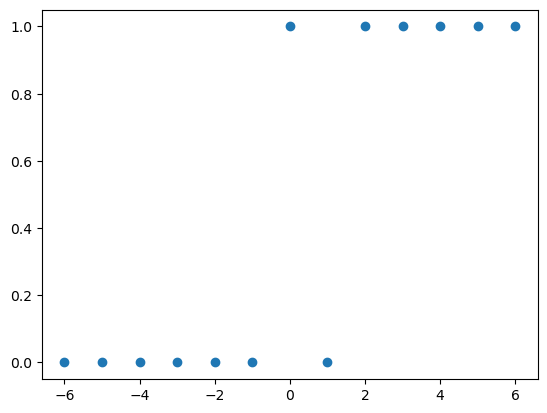

In [40]:
x = torch.tensor([-6,-5,-4,-3,-2,-1, 0, 1, 2, 3, 4, 5, 6.0]).reshape(-1,1)
y = torch.tensor([ 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]).reshape(-1,1)
plt.plot(x,y,'o')

- yhat이 굳이 0 혹은 1이어야 할까? 
- (회귀문제를 떠올리며) 우리가 맞추고 싶은건 사실 $y_i$ 자체가 아니라 $y_i$를 만들어내는 underlying 아니었어? 

`-` 아래와 같이 모형화 하면? 

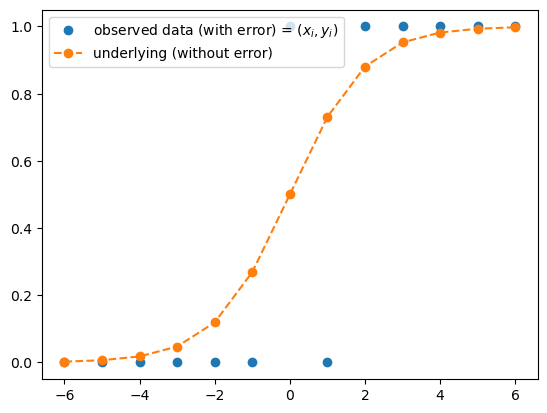

In [41]:
plt.plot(x,y,'o', label=r"observed data (with error) = $(x_i,y_i)$")
plt.plot(x,torch.exp(x)/(1+torch.exp(x)),'o--', label = "underlying (without error)")
plt.legend()

- 우리가 예측하고 싶은건 랜덤하게 나오는 오차가 아니야. (만약 예측할 수 있다면 이미 랜덤이 아닌걸?)

# 4. ToyData2

## A. 로지스틱 모형

`-` $x$가 커질수록 $y=1$이 잘나오는 모형은 아래와 같이 설계할 수 있음
\<— 외우세요!!!

-   $y_i \sim {\cal B}(\pi_i),\quad$ where
    $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)} = \frac{1}{1+\exp(-w_0-w_1x_i)}$

-   $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$

-   $loss= - \sum_{i=1}^{n} \big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$
    \<— 외우세요!!

`-` 회귀모형과 로지스틱 모형의 비교 

- 회귀모형: $y_i \sim {\cal N}(w_0+w_1x_i, \sigma^2)$^[원래는 이렇게 썼었지.. $y_i = w_0 + w_1x_i + \epsilon_i \quad \epsilon_i \sim {\cal N}(0,\sigma^2)$]
- 로지스틱: $y_i \sim {\cal B}\big(\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}\big)$

`-` 우리가 예측하고 싶은것 

- 회귀모형: 정규분포의 평균을 예측하고 싶음. 즉 $w_0+w_1x_i$를 예측하고 싶음. 예측값으로는 $\hat{w}_0 + \hat{w}_1x_i$를 사용!
- 로지스틱: 베르누이의 평균을 예측하고 싶음. 즉 $\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$를 예측하고 싶음. 예측값으로는 $\frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}$를 사용!

## B. 데이터 

In [42]:
x = torch.linspace(-3,3,2000).reshape(2000,1)
w0 = -1
w1 = 5
u = w0 + x*w1 # 선형변환이네?
v = torch.exp(u) / (1+torch.exp(u))  # 시그모이드 함수  
y = torch.bernoulli(v)               # 베르누이 분포

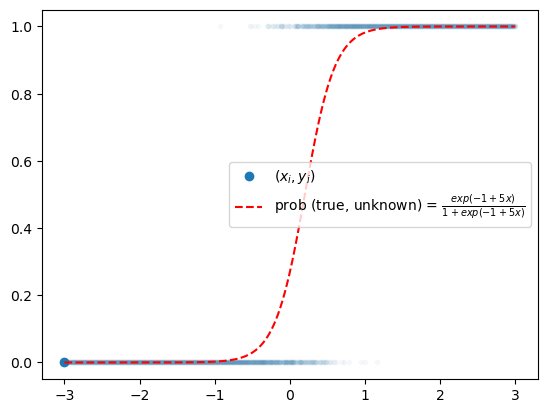

In [43]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.legend()

우리의 목적: $x_i$가 들어가면 빨간곡선 $\hat{y}_i$의 값을 만들어주는 mapping을 학습해보자. 

## C. Step1: net 설계 (모델링)

`-` 최초의 곡선을 그려보자. ($net: x \to yhat$ 을 수행하는 네트워크를 설계해보자는 의미)

In [44]:
w0hat = -0.8
w1hat = -0.3

In [45]:
# custom sigmoid function
def sigmoid(x):
    return torch.exp(x)/(1+torch.exp(x))

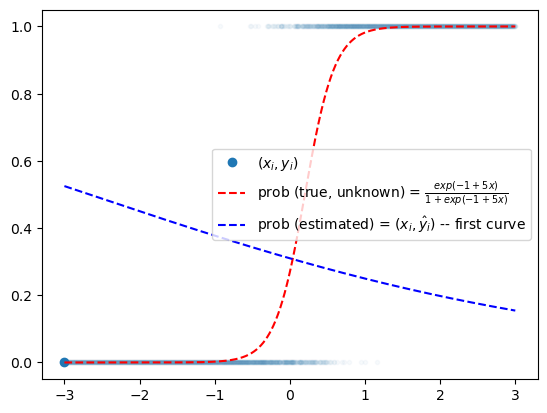

In [46]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,sigmoid(w0hat + w1hat*x),'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
plt.legend()

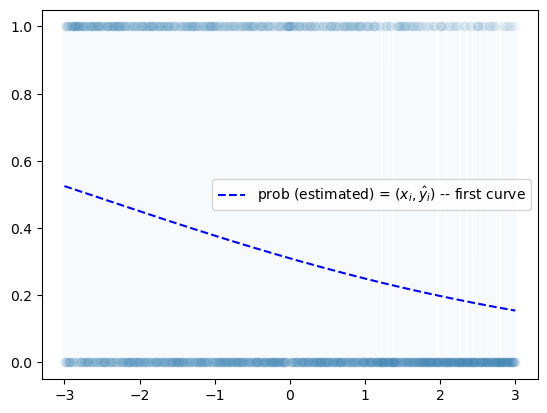

In [47]:
# 현재 추정하고 있는 model의 plot상태. Ground Truth와 사뭇 다르다. 이를 수정해서 Ground Truth에 가깝도록 튜닝해야됨.
plt.plot(x,sigmoid(w0hat + w1hat*x),'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
plt.plot(x,torch.bernoulli(sigmoid(w0hat + w1hat*x)),'-o',alpha=0.03)
plt.legend()

In [48]:
w0hat,w1hat

(-0.8, -0.3)

`-` `w0hat + w1hat*x` 이 부분을 `torch.nn.Linear(bias = False)`로 구현

In [49]:
X = torch.concat([torch.ones(2000).reshape(-1,1),x],axis=1)
l1 = torch.nn.Linear(
    in_features=2,
    out_features=1,
    bias=False
)

l1.weight   # random w0, w1

Parameter containing:
tensor([[0.6654, 0.1551]], requires_grad=True)

In [50]:
l1.weight.data = torch.tensor([[-0.8,  -0.3]])      # shape에 주의. 

In [51]:
l1.weight.data.shape

torch.Size([1, 2])

In [52]:
l1(X), w0hat + w1hat*x # 똑같죠

(tensor([[ 0.1000],
         [ 0.0991],
         [ 0.0982],
         ...,
         [-1.6982],
         [-1.6991],
         [-1.7000]], grad_fn=<MmBackward0>),
 tensor([[ 0.1000],
         [ 0.0991],
         [ 0.0982],
         ...,
         [-1.6982],
         [-1.6991],
         [-1.7000]]))

`-` `w0hat + w1hat*x` 이 부분을 `torch.nn.Linear(bias = True)`로 구현

In [53]:
#X = torch.concat([torch.ones(2000).reshape(-1,1),x],axis=1)
l1 = torch.nn.Linear(in_features=1, out_features=1) # bias=True 기본
l1.weight, l1.bias

(Parameter containing:
 tensor([[-0.8022]], requires_grad=True),
 Parameter containing:
 tensor([0.4586], requires_grad=True))

In [54]:
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])

In [55]:
l1(x), w0hat + w1hat*x # 이것도 똑같죠!

(tensor([[ 0.1000],
         [ 0.0991],
         [ 0.0982],
         ...,
         [-1.6982],
         [-1.6991],
         [-1.7000]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.1000],
         [ 0.0991],
         [ 0.0982],
         ...,
         [-1.6982],
         [-1.6991],
         [-1.7000]]))

`-` 내가만든 sigmoid 대신에 토치에서 제공하는 sigmoid 사용 

In [56]:
a1 = torch.nn.Sigmoid()

In [57]:
a1(l1(x)) # 똑같아요. sigmoid 에 linear transform 한 x 를 통과시킴

tensor([[0.5250],
        [0.5248],
        [0.5245],
        ...,
        [0.1547],
        [0.1546],
        [0.1545]], grad_fn=<SigmoidBackward0>)

In [58]:
sigmoid(l1(x)) # 똑같아요

tensor([[0.5250],
        [0.5248],
        [0.5245],
        ...,
        [0.1547],
        [0.1546],
        [0.1545]], grad_fn=<DivBackward0>)

In [59]:
sigmoid(l1(x)),   a1(l1(x)) # 똑같아요

(tensor([[0.5250],
         [0.5248],
         [0.5245],
         ...,
         [0.1547],
         [0.1546],
         [0.1545]], grad_fn=<DivBackward0>),
 tensor([[0.5250],
         [0.5248],
         [0.5245],
         ...,
         [0.1547],
         [0.1546],
         [0.1545]], grad_fn=<SigmoidBackward0>))

`-` 지금까지의 구현 확인 

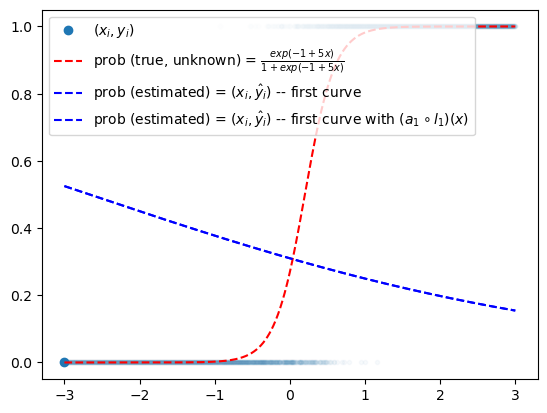

In [60]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,sigmoid(w0hat + w1hat*x),'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
plt.plot(x,a1(l1(x)).data,'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve with $(a_1 \circ l_1)(x)$")
plt.legend()

`-` 관찰: 지금 아래의 구조이다. 

$${\boldsymbol x} \overset{l_1}{\to} {\boldsymbol u} \overset{a_1}{\to} {\boldsymbol v} = \hat{\boldsymbol y}$$

l1 함수는 linear transform을, a1 함수는 sigmoid 변환을 의미한다.  
  
l1 = torch.nn.Linear(in_features=1, out_features=1) # bias=True 기본  
a1 = torch.nn.Sigmoid()  

`-` 소망: 함수 $l_1, a_1$ 의 합성을 하나로 묶어서 

$$(a_1\circ l_1)({\boldsymbol x}) := net({\boldsymbol x})$$

이러한 기능을 하는 하나의 함수 $net$을 만들 수 없을까? 

In [61]:
torch.nn.Sequential?

Init signature: torch.nn.Sequential(*args)
Docstring:     
A sequential container.

Modules will be added to it in the order they are passed in the
constructor. Alternatively, an ``OrderedDict`` of modules can be
passed in. The ``forward()`` method of ``Sequential`` accepts any
input and forwards it to the first module it contains. It then
"chains" outputs to inputs sequentially for each subsequent module,
finally returning the output of the last module.

The value a ``Sequential`` provides over manually calling a sequence
of modules is that it allows treating the whole container as a
single module, such that performing a transformation on the
``Sequential`` applies to each of the modules it stores (which are
each a registered submodule of the ``Sequential``).

What's the difference between a ``Sequential`` and a
:class:`torch.nn.ModuleList`? A ``ModuleList`` is exactly what it
sounds like--a list for storing ``Module`` s! On the other hand,
the layers in a ``Sequential`` are connected

In [62]:
net = torch.nn.Sequential(l1,a1) #l1을 취하고 그다음에 a1을 취하라는 의미

In [63]:
net(x), a1(l1(x)), sigmoid(w0hat+ w1hat*x)  # 셋이 똑같음

(tensor([[0.5250],
         [0.5248],
         [0.5245],
         ...,
         [0.1547],
         [0.1546],
         [0.1545]], grad_fn=<SigmoidBackward0>),
 tensor([[0.5250],
         [0.5248],
         [0.5245],
         ...,
         [0.1547],
         [0.1546],
         [0.1545]], grad_fn=<SigmoidBackward0>),
 tensor([[0.5250],
         [0.5248],
         [0.5245],
         ...,
         [0.1547],
         [0.1546],
         [0.1545]]))

`-` net 살펴보기: 초보버전 -- "파이토치 30일만에 완성하기" 이런책에 보면 내용이 나올지도?

In [64]:
net

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)

- 처음에는 선형변환하고, 그담에는 Sigmoid를 수행하라는 의미

`-` net 살펴보기: 고수버전 -- 책 안보고 코딩배우기

In [65]:
set(dir(net)) & {'__call__', '__getitem__'}

{'__call__', '__getitem__'}

- 좋은거 가지고 있네 ㅎㅎ 
- callable 이면서 subscriptable 오브젝트.. 

In [66]:
lst = [11,22,33]
lst.__getitem__(-1) # lst[-1]

33

In [67]:
sigmoid.__call__(x) # sigmoid(x)

tensor([[0.0474],
        [0.0476],
        [0.0477],
        ...,
        [0.9523],
        [0.9524],
        [0.9526]])

In [68]:
sigmoid[0] # 난 스크립터블 하지 않은걸? (= 난 리스트처럼 인덱싱 못해요)

TypeError: 'function' object is not subscriptable

In [ ]:
lst(x)# 난 컬러블하지 않은걸? (= 난 함수처럼 입력을 받고 출력을 주는 일은 못해요)

In [ ]:
net(x) # 컬러블이면서

In [ ]:
net[0]# 섭스크립터블

In [ ]:
net[1]# 섭스크립터블

In [ ]:
_l1, _a1 = net # 언패킹!! (섭스크립터블하니까..)

In [ ]:
_l1.weight, _l1.bias # 내가 설정한 웨이트도 그대로 들어가있음

## D. Step 1~4

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net # 네트워크는 섭스크립터블 오브젝트이니까..  , 언패킹도 가능
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
#loss_fn = torch.nn.MSELoss() # -- 이 코드 일단 쓰지 않을게여
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
# plt.plot(x,y-yhat.data,'--g',alpha=0.6)
plt.title('after 100 epochs')

In [ ]:
for epoc in range(4900):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 5000 epochs')

성공했나? 

# 5. 학습과정 시각화 및 문제인식 

## A. 좋은 초기값

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## B. 가능성 있는 초기값 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
# A 케이스에서 초기값만 -3,-1 으로 바꾼 경우 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## C. 최악의 초기값

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

해결하는 접근법:

- 컴공스타일: 에폭을 늘려볼까?
- 산공스타일: 옵티마이저를 바꿔볼까? 
- 통계스타일: Loss를 바꿔볼까?

# 6. 손실함수의 개선 (통계스타일)

## A. BCE Loss를 사용하여 학습

`-` BCE loss라는게 있음. 

- <https://en.wikipedia.org/wiki/Cross-entropy>
강의 **21:20** 에서, `-torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat)` 수식이 베르누이 분포의 -log likelihood 와 같고,  
이 수식은 두번 미분했을때 음수, 즉 convex하다는게 이미 증명되어있다.
즉 BCE loss는 convex하기때문에 비선형성이 MSE 보다 작아서 해당 경우에 유리하다. 

`-` 강의 **21:55** 에서 회귀 분석(regression)에서는 그러면 왜 BCE를 안 썼냐?
- 회귀분석에서는 binomial(bernoui) 이 아닌 nomal(error를 정규분포라 가정했으므로) 에서 평균을 추정하는 문제였으며, 이 경우에는 MSE가 convex하다고 증명되어있다고 한다.

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net # 네트워크는 섭스크립터블 오브젝트이니까..
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    #loss = torch.mean((y-yhat)**2)
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))     # 직접 BCE 를 공식으로 구현
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
y*torch.log(yhat)

In [ ]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

In [ ]:
# plt.plot(x,y,'.',alpha=0.05)
# plt.plot(x,v,'--r')
# plt.plot(x,yhat.data,'--b')
# plt.plot(x,y-yhat.data,'--g',alpha=0.6)
# plt.title('after 100 epochs')

In [ ]:
sigmoid(l1(x)),   a1(l1(x)) # 똑같아요

같은 100 에폭인데 훨씬 잘맞춤..

`-` loss수식을 못외우겠다면? 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net # 네트워크는 섭스크립터블 오브젝트이니까..
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
#loss_fn = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))     # 직접 BCE 를 공식으로 구현 ,  맞는걸(y=1) 틀리다(yhat=0) 하고, 틀린걸(y=0) 맞다고(yhat=1) 하면 loss가 커짐. 즉 안 좋아짐.
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) # yhat부터 써야함
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

## B. Loss Function 시각화

In [ ]:
plot_loss(torch.nn.MSELoss())

In [ ]:
plot_loss(torch.nn.BCELoss())

`-` 비교해보자. 

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
plot_loss(torch.nn.MSELoss(),ax1)
plot_loss(torch.nn.BCELoss(),ax2)

## C. 학습과정 시각화 -- 좋은 초기값

`-` MSELoss 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 학습과정 시각화 -- 가능성 있는 초기값

`-` MSELoss 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## E. 학습과정 시각화 -- 최악의 초기값

`-` MSELoss 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

# 7. 옵티마이저의 개선 (산공 스타일)

## C. 학습과정 시각화 -- 좋은 초기값

`-` MSELoss + SGD 

In [ ]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-0.8470])
# net[0].weight.data = torch.tensor([[-0.3467]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()        # 일부로 좋은? loss 인 BCE 를 안 주고, 안 좋은 MSE loss를 줘봤다.  opitimizer를 SGD에서 Adam으로 바꿈으로서 잘 수렴하는지 확인해보자!
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 학습과정 시각화 -- 가능성 있는 초기값

`-` MSELoss + SGD

In [ ]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-3.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()    # 일부로 좋은? loss 인 BCE 를 안 주고, 안 좋은 MSE loss를 줘봤다.  opitimizer를 SGD에서 Adam으로 바꿈으로서 잘 수렴하는지 확인해보자!
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## E. 학습과정 시각화 -- 최악의 초기값

`-` MSELoss + SGD

In [ ]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-10.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()    # 일부로 좋은? loss 인 BCE 를 안 주고, 안 좋은 MSE loss를 줘봤다.  opitimizer를 SGD에서 Adam으로 바꿈으로서 잘 수렴하는지 확인해보자!
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

# 8. 로지스틱의 한계 

## A. 신문기사 (데이터의 모티브)

`-` [스펙이 높아도 취업이 안된다고
합니다..](https://www.joongang.co.kr/article/23637092#home)

**중소·지방 기업 “뽑아봤자 그만두니까”**

중소기업 관계자들은 고스펙 지원자를 꺼리는 이유로 높은 퇴직률을 꼽는다.
여건이 좋은 대기업으로 이직하거나 회사를 관두는 경우가 많다는 하소연이다. 
고용정보원이 지난 3일 공개한 자료에 따르면 중소기업 청년취업자 가운데 49.5%가 2년 내에 회사를 그만두는 것으로 나타났다.

중소 IT업체 관계자는 “기업 입장에서 가장 뼈아픈 게 신입사원이 그만둬서 새로 뽑는 일”이라며 “명문대 나온 스펙 좋은 지원자를 뽑아놔도 1년을
채우지 않고 그만두는 사원이 대부분이라 우리도 눈을 낮춰 사람을 뽑는다”고 말했다.

## B. 가짜데이터 

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
df

In [ ]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

## C. 로지스틱으로 적합 

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---# 
for epoc in range(5000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data, '--', label= r"prob (estimated) = $(x_i,\hat{y}_i)$")
plt.legend()

`-` Epoch을 10억번으로 설정해도 이건 못 맞출것 같음. 

- 결국 올라가다가 내려가는 언더라잉을 맞춰야 하는데 현재 모형으로는 이걸 표현할 수 없다. 
- 모형의 표현력이 낮다. 

## D. 해결책 (아이디어 수준만)

`-` sigmoid를 넣기 전의 상태가 직선이 아니라 꺽이는 직선이야 한다. 

In [ ]:
a = torch.nn.Sigmoid()

In [ ]:
fig,ax = plt.subplots(4,2,figsize=(8,8))
u1 = torch.tensor([-6,-4,-2,0,2,4,6])
u2 = torch.tensor([6,4,2,0,-2,-4,-6])
u3 = torch.tensor([-6,-2,2,6,2,-2,-6])
u4 = torch.tensor([-6,-2,2,6,4,2,0])
ax[0,0].plot(u1,'--o',color='C0',label = r"$u_1$")
ax[0,0].legend()
ax[0,1].plot(a(u1),'--o',color='C0',label = r"$a(u_1)=\frac{exp(u_1)}{exp(u_1)+1}$")
ax[0,1].legend()
ax[1,0].plot(u2,'--o',color='C1',label = r"$u_2$")
ax[1,0].legend()
ax[1,1].plot(a(u2),'--o',color='C1',label = r"$a(u_2)=\frac{exp(u_2)}{exp(u_2)+1}$")
ax[1,1].legend()
ax[2,0].plot(u3,'--o',color='C2', label = r"$u_3$")
ax[2,0].legend()
ax[2,1].plot(a(u3),'--o',color='C2', label = r"$a(u_3)=\frac{exp(u_3)}{exp(u_3)+1}$")
ax[2,1].legend()
ax[3,0].plot(u4,'--o',color='C3', label = r"$u_4$")
ax[3,0].legend()
ax[3,1].plot(a(u4),'--o',color='C3', label = r"$a(u_4)=\frac{exp(u_4)}{exp(u_4)+1}$")
ax[3,1].legend()

# 9. HW 

강의노트의 로직스틱 예제 `ToyData2` 에 소개된 데이터를 불러오고, 다양한 초기값에서 BCE loss 와 Adma을 이용하여 학습한뒤 시각화하라.